In [20]:
import torch
import numpy as np
from models import Discriminator_MLP_Skip
from data_PET import read_data, get_data_loaders

# Load data
uPiB, uFBP, pPiB, pFBP, uPiB_CL, uFBP_CL, uPiB_scaler, uFBP_scaler = read_data(normalize=False)
val_dataloader, dataloader = get_data_loaders(uPiB, uFBP, pPiB, pFBP, uPiB_CL, uFBP_CL, 
                                                  128, 46, resample='matching')

model_FBP_path = './training_logs_matching_mc_l2/saved_model/160_160_8_10_1_10.0_5.0_5.0/D_A_Best.pth'
model_PiB_path = './training_logs_matching_mc_l2/saved_model/160_160_8_10_1_10.0_5.0_5.0/D_B_Best.pth'

Dis_FBP = Discriminator_MLP_Skip(85, 160, 10)
Dis_PiB = Discriminator_MLP_Skip(85, 160, 10)
Dis_FBP.load_state_dict(torch.load(model_FBP_path))
Dis_PiB.load_state_dict(torch.load(model_PiB_path))

Dis_FBP.eval()
Dis_PiB.eval()

# combine uPiB and uFBP as one dataset uPiB with label 0 and uFBP with label 1
uPiB = torch.tensor(uPiB).float()
uFBP = torch.tensor(uFBP).float()
Data_cls = torch.cat((uPiB, uFBP))
label_cls = torch.cat((torch.zeros(uPiB.shape[0]), torch.ones(uFBP.shape[0])))
print(Data_cls.shape)
pPiB = torch.tensor(pPiB).float()
pFBP = torch.tensor(pFBP).float()
Data_cls_test = torch.cat((pPiB, pFBP))
label_cls_test = torch.cat((torch.zeros(pPiB.shape[0]), torch.ones(pFBP.shape[0])))
print(Data_cls_test.shape)

# data loader
train_data = torch.utils.data.TensorDataset(Data_cls, label_cls)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_data = torch.utils.data.TensorDataset(Data_cls_test, label_cls_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)


torch.Size([4674, 85])
torch.Size([92, 85])


In [16]:
uFBP.shape

torch.Size([2717, 85])

In [9]:
Dis_NEW = Discriminator_MLP_Skip(85, 128, 8)
# train the new discriminator
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(Dis_NEW.parameters(), lr=0.0001)
num_epochs = 100

for epoch in range(num_epochs):
    Dis_NEW.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = Dis_NEW(images)
        loss = criterion(outputs.ravel(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Dis_NEW.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = Dis_NEW(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.ravel() == labels).sum().item()
        print('Epoch [{}/{}], Accuracy: {:.4f}'.format(epoch+1, num_epochs, correct/total))
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/100], Accuracy: 0.5000
Epoch [1/100], Loss: 0.6624
Epoch [2/100], Accuracy: 0.5109
Epoch [2/100], Loss: 0.5860
Epoch [3/100], Accuracy: 0.6630
Epoch [3/100], Loss: 0.4052
Epoch [4/100], Accuracy: 0.8261
Epoch [4/100], Loss: 0.1740
Epoch [5/100], Accuracy: 0.8370
Epoch [5/100], Loss: 0.0593
Epoch [6/100], Accuracy: 0.8587
Epoch [6/100], Loss: 0.2537
Epoch [7/100], Accuracy: 0.7065
Epoch [7/100], Loss: 0.1599
Epoch [8/100], Accuracy: 0.8696
Epoch [8/100], Loss: 0.1505
Epoch [9/100], Accuracy: 0.8587
Epoch [9/100], Loss: 0.1059
Epoch [10/100], Accuracy: 0.8261
Epoch [10/100], Loss: 0.1757
Epoch [11/100], Accuracy: 0.8696
Epoch [11/100], Loss: 0.1138
Epoch [12/100], Accuracy: 0.8696
Epoch [12/100], Loss: 0.1199
Epoch [13/100], Accuracy: 0.8696
Epoch [13/100], Loss: 0.1241
Epoch [14/100], Accuracy: 0.8804
Epoch [14/100], Loss: 0.1844
Epoch [15/100], Accuracy: 0.8913
Epoch [15/100], Loss: 0.0967
Epoch [16/100], Accuracy: 0.8913
Epoch [16/100], Loss: 0.1114
Epoch [17/100], Accuracy: 

KeyboardInterrupt: 

In [21]:
# classification
for data in val_dataloader:
    real_FBP, real_PiB = data
    p_FBP_FBP = Dis_FBP(real_PiB)
    p_FBP_PiB = Dis_PiB(real_FBP)
    p_PiB_FBP = Dis_FBP(real_FBP)
    p_PiB_PiB = Dis_PiB(real_PiB)
    
    acc_FBP_FBP = (p_FBP_FBP > 0.5).sum().item() / p_FBP_FBP.size(0)
    acc_PiB_PiB = (p_PiB_PiB > 0.5).sum().item() / p_PiB_PiB.size(0)
    acc_PiB_FBP = (p_PiB_FBP < 0.5).sum().item() / p_PiB_FBP.size(0)
    acc_FBP_PiB = (p_FBP_PiB < 0.5).sum().item() / p_FBP_PiB.size(0)
    print('FBP_FBP: ', acc_FBP_FBP, 'PiB_PiB: ', acc_PiB_PiB, 'PiB_FBP: ', acc_PiB_FBP, 'FBP_PiB: ', acc_FBP_PiB)

FBP_FBP:  0.21739130434782608 PiB_PiB:  0.391304347826087 PiB_FBP:  0.5434782608695652 FBP_PiB:  0.9130434782608695


Text(0.5, 1.0, 'FBP Discriminator')

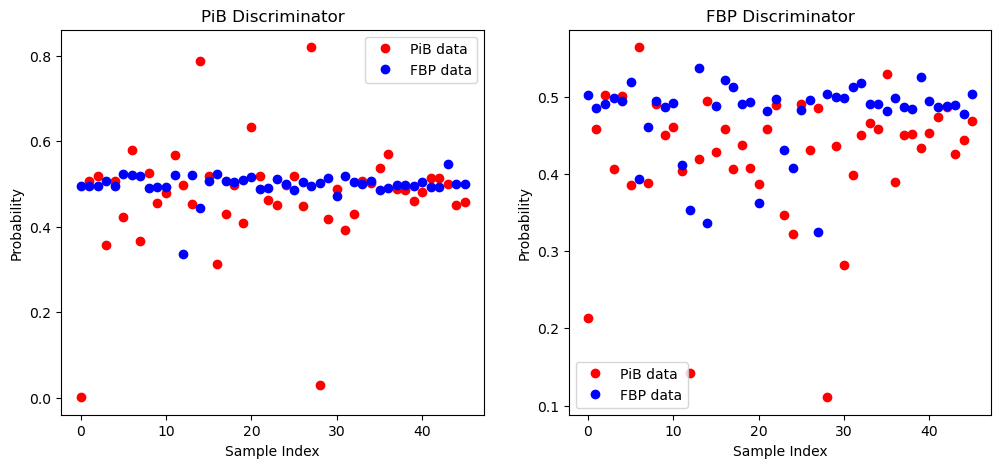

In [37]:
import matplotlib.pyplot as plt

p_PiB_PiB_np = p_PiB_PiB.detach().numpy()
p_PiB_FBP_np = p_PiB_FBP.detach().numpy()
p_FBP_FBP_np = p_FBP_FBP.detach().numpy()
p_FBP_PiB_np = p_FBP_PiB.detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(p_PiB_PiB_np, 'ro', label='PiB data')
ax[0].plot(p_PiB_FBP_np, 'bo', label='FBP data')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].set_title('PiB Discriminator')

ax[1].plot(p_FBP_PiB_np, 'ro', label='PiB data')
ax[1].plot(p_FBP_FBP_np, 'bo', label='FBP data')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Probability')
ax[1].legend()
ax[1].set_title('FBP Discriminator')




PermutationExplainer explainer: 93it [00:24,  2.29it/s]                        


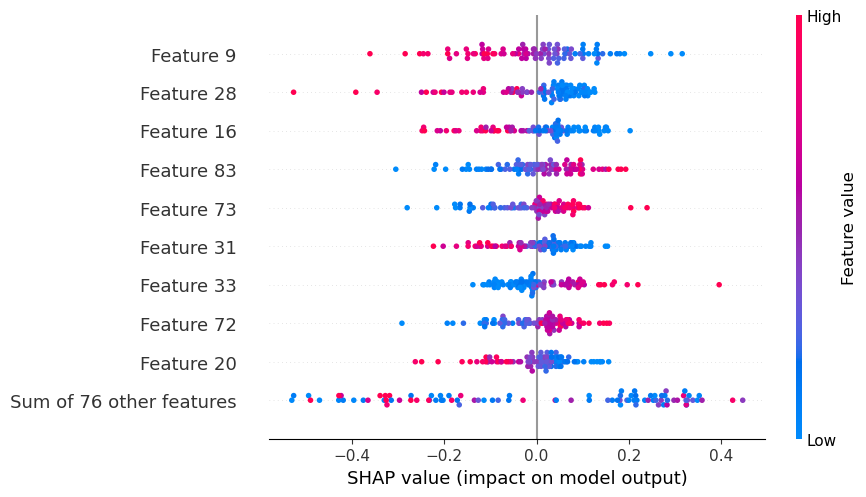

In [14]:
import shap
shap.initjs()

def f(X):
    X = torch.tensor(X, dtype=torch.float32)
    p = Dis_NEW(X)
    return p.detach().numpy()

for data in test_loader:
    data_shap, _ = data
explainer = shap.Explainer(f, data_shap.numpy())
shap_values = explainer(data_shap.numpy())
shap.plots.beeswarm(shap_values)